# GradedLab 1 
## Task 1: Monte Carlo with random policy

In [39]:
# Dependencies

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
from typing import NamedTuple
from gymnasium.envs.toy_text.frozen_lake import generate_random_map

In [40]:
class Params(NamedTuple):
    total_episodes: int 
    map_size: int
    seed: int
    is_slippery: bool
    proba_frozen: float

In [ ]:
# Plots
def plot_trajectory_lengths(trajectory_lengths):
    plt.figure(figsize=(10, 5))
    plt.plot(trajectory_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Trajectory Length (Steps)")
    plt.title("Length of Trajectories per Episode")
    plt.show()

def plot_learning_curve(episode_returns):
    plt.figure(figsize=(10, 5))
    cumulative_returns = np.cumsum(episode_returns)
    plt.plot(cumulative_returns)
    plt.xlabel("Episode")
    plt.ylabel("Cumulative Reward")
    plt.title("Learning Curve (Cumulative Reward over Episodes)")
    plt.show()

def plot_value_function(V, params: Params):
    size = params.map_size
    values = np.zeros((size, size))
    for state in range(len(V)):
        row, col = divmod(state, size)
        values[row, col] = V[state]
    
    plt.figure(figsize=(7, 6))  
    plt.imshow(values, cmap='viridis', interpolation='nearest') 
    plt.colorbar(label="State-Value (V)")
    plt.title("State-Value Function (Monte Carlo First-Visit)")
    plt.xlabel("State (Columns)")
    plt.ylabel("State (Rows)")
    
    for i in range(size):
        for j in range(size):
            plt.text(j, i, f"{values[i, j]:.2f}", ha='center', va='center', color="white" if values[i, j] < 0.3 else "black")
    
    plt.show()

In [ ]:
# Generate an episode with random policy
def generate_episode(env):
    episode = []
    state, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # random action
        next_state, reward, done, _, *_ = env.step(action)
        episode.append((state, action, reward))
        state = next_state
    return episode

# Monte Carlo with First-Visit
def monte_carlo_first_visit(params: Params):
    random_map = generate_random_map(size=params.map_size, p=params.proba_frozen)
    env = gym.make("FrozenLake-v1", desc=random_map, is_slippery=params.is_slippery)
    env.reset(seed=params.seed)

    # Initialize value arrays and other tracking variables
    V = np.zeros(env.observation_space.n)
    returns_sum = np.zeros(env.observation_space.n)
    returns_count = np.zeros(env.observation_space.n)
    episode_lengths = []
    episode_returns = []
    
    for episode in range(params.total_episodes):
        episode_data = generate_episode(env)
        episode_lengths.append(len(episode_data))
        
        G = 0  # cumulative reward
        visited_states = set()  # Track visited states within this episode
        
        for t in reversed(range(len(episode_data))):
            state, action, reward = episode_data[t]
            G += reward
            
            # First-Visit check
            if state not in visited_states:
                visited_states.add(state)
                
                # Increment returns sum and count for averaging
                returns_sum[state] += G
                returns_count[state] += 1
                V[state] = returns_sum[state] / returns_count[state]
                
        episode_returns.append(G)

    return V, episode_lengths, episode_returns

### 5x5 Map

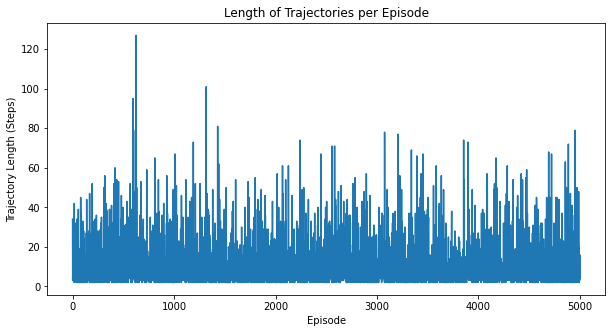

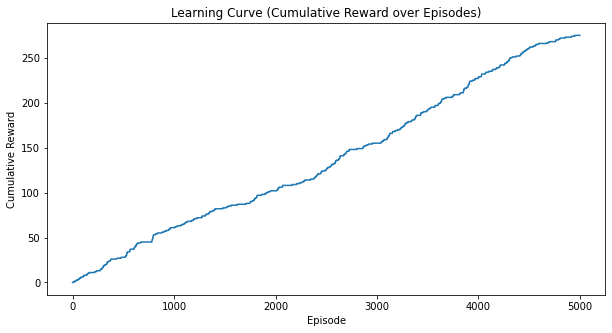

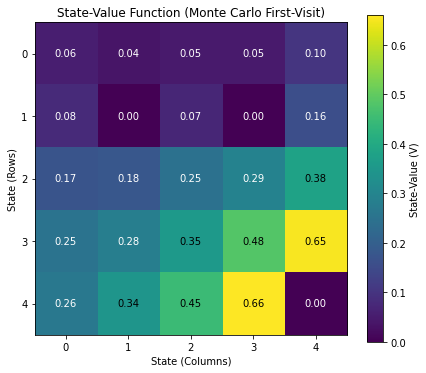

In [ ]:
params_5x5 = Params(total_episodes=5000, map_size=5, seed=123, is_slippery=False, proba_frozen=0.9)
V_5x5, trajectory_lengths_5x5, episode_returns_5x5 = monte_carlo_first_visit(params_5x5)

plot_trajectory_lengths(trajectory_lengths_5x5)
plot_learning_curve(episode_returns_5x5)
plot_value_function(V_5x5, params_5x5)

### 11x11 Map

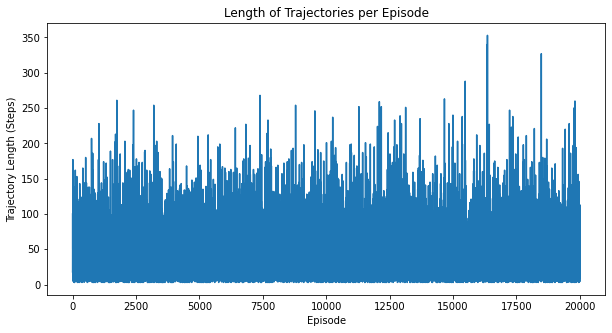

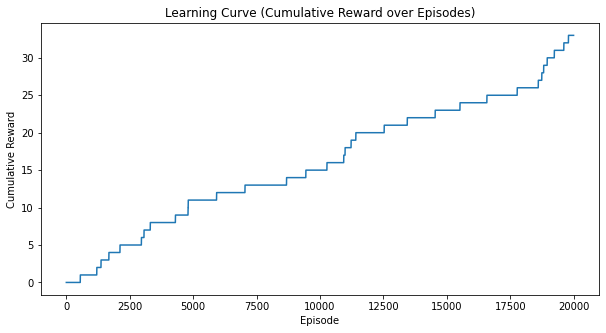

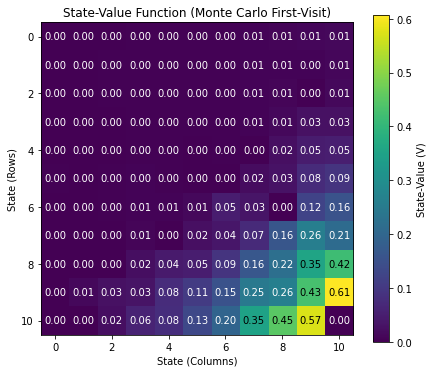

In [48]:
params_11x11 = Params(total_episodes=20000, map_size=11, seed=123, is_slippery=False, proba_frozen=0.9)
V_11x11, trajectory_lengths_11x11, episode_returns_11x11 = monte_carlo_first_visit(params_11x11)

plot_trajectory_lengths(trajectory_lengths_11x11)
plot_learning_curve(episode_returns_11x11)
plot_value_function(V_11x11, params_11x11)

## QA

### Parameters

<strong>total_episodes=5000</strong><br><br>
A total of 5,000 episodes allows the agent to explore a sufficient number of trajectories in the environment. Since we are using a Monte Carlo approach, which relies on sampling complete episodes, a larger number of episodes helps the agent gather enough data to estimate the state-value function more accurately, even when actions are selected randomly. This number provides a balance between computational efficiency and obtaining a reliable estimate of the state values.

<strong>is_slippery=False</strong><br><br>
Setting `is_slippery=False` removes the stochastic element of movement in Frozen Lake, making it a deterministic environment. This means that when the agent takes an action, it moves in the intended direction without the risk of slipping to a random adjacent tile. A deterministic environment simplifies the learning process and allows for a clearer evaluation of the Monte Carlo method without added randomness in state transitions. This makes it easier to observe the effects of the random policy on the value estimation alone.

<strong>proba_frozen=0.9</strong><br><br>
A high probability (90%) of frozen tiles means that the majority of the grid will be traversable, with only a few tiles potentially being holes. This makes it more likely that the agent will reach the goal in most episodes, allowing it to gather more data on successful trajectories. This setting supports the goal of value estimation without the agent frequently falling into holes, which would add noise to the returns and make it harder to observe consistent trends in the value function.

<strong>Comparison total_episodes=20000</strong><br><br>
In the plot with 20,000 episodes, the trajectory lengths show a wider spread and higher variability in the number of steps per episode. This increased variability is expected with a larger state space (11x11 grid) and higher number of episodes, as the agent continues to explore randomly over a much larger area.

The longer episode count allows the agent to sample more diverse trajectories, which helps in capturing the complex layout of the larger grid. However, even with 20,000 episodes, the random policy does not necessarily yield efficient trajectories, as shown by the frequent spikes in trajectory lengths.

The cumulative reward plot for 20,000 episodes shows a slow, step-like progression, indicating infrequent successful completions of episodes with positive rewards. The increase is more gradual and sparse compared to the 5,000-episode run, likely due to the increased difficulty in reaching the goal in the larger grid environment.

The state-value heatmap after 20,000 episodes displays a clear gradient, with values increasing as states get closer to the goal in the bottom-right corner. Compared to the 5,000-episode case, the additional episodes have allowed the agent to refine its estimates of state values, particularly in areas close to the goal.

### Choice of Incremental MC Implementation (First-Visit / Multiple-Visits)

 For this assignment, we chose the First-Visit Monte Carlo approach because it provides an unbiased estimation of the value function, as each state's first visit is treated as an independent sample. In stochastic environments like Frozen Lake, this helps ensure that our estimates are not skewed by repeated visits to the same state within a single trajectory, which can lead to redundant data in the case of Multiple-Visit. This also aligns with standard reinforcement learning practices where First-Visit Monte Carlo is often preferred due to its unbiased nature.

### List of Hyperparameter Values Chosen for Each Method, and Selection Approach

For the random policy, there are no hyperparameters to tune. The random policy simply selects actions uniformly from the available action space without any dependence on learned values or exploration rates.

In a random policy, the agent’s actions do not depend on learned information or environmental feedback. This lack of dependency means we have no parameters to adjust, as the policy is inherently stochastic and fixed by design. This approach provides a baseline to assess performance without additional complexity from exploration-exploitation balancing or value estimation.

### Is the Agent Able to Estimate the Value Function Correctly?

The agent is able to estimate an approximate value function for the environment. In the state-value function heatmap, we observe that states closer to the goal (bottom right corner) have higher values, while states further away generally have lower values. This indicates that the agent has correctly captured the general structure of the environment, where proximity to the goal state corresponds to higher returns. However, since the policy is random, the values are not optimal and reflect the average returns under a random policy rather than a strategic or goal-oriented policy.

### Is the Agent Able to Learn the Right Policy?

No, the agent does not learn the optimal policy with the random action selection approach. The trajectory length plot shows high variability in the number of steps required to complete episodes, indicating inconsistency in reaching the goal efficiently. Furthermore, the cumulative reward plot increases slowly and steadily, showing that while the agent accumulates some rewards over time, it does not improve in a way that would signify learning an efficient policy. To learn the right policy, the agent would need a mechanism to exploit higher-value states by following a more directed strategy, rather than acting randomly.